<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">


<h1 align="center", style="margin-bottom: -10px">Предсказание температуры стали на этапе обработки<a class="tocSkip"></h1>
<h4 align="center", style="margin-bottom: 60px">Выпускной проект, Яндекс Практикум <a class="tocSkip"> </h4>
<h4 align="right", style="margin-bottom: -15px">Исполнитель: Воронин Артём<a class="tocSkip"></h4> 

<h1>Содержание<span class="tocSkip"></span></h1>
<p style="margin-bottom: 30px"></p> 

[Описание проекта](#Описание-проекта)  
[1 Подготовка к работе](#1-Подготовка-к-работе)  
[2 Исследовательский анализ данных и предобработка](#2-Исследовательский-анализ-данных-и-предобработка)  
[3 Подготовка данных для обучения](#3-Подготовка-данных-для-обучения)  
[4 Обучение моделей](#4-Обучение-моделей)  
[5 Тестирование](#5-Тестирование)  
[ВЫВОДЫ](#ВЫВОДЫ)

<h1 align="center">Описание проекта</h1>
<h2>Задача проекта:<span class="tocSkip"></span></h2>

Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы. Необходимо построить модель машинного обучения для предсказания температуры стали с целевой метрикой **MAE** не более **6,8**.

<p style="margin-bottom: 30px"></p>

<h2> Дополнительные начальные условия: <span class="tocSkip"></span> </h2>

- Целевая переменная (target) - последняя по времени измеренная температура по всей партии;  
- Использовать как признак можно только первую температуру партии;
- Использовать везде random_state = 80523;
- Удалить следующие записи:
    - с температурой ниже 1500;
    - с отрицательной реактивной мощностью;
    - с ключом с одним замером;
- агрегировать данные в тех таблицах, где для одной партии имеются несколько итераций (строк).
<p style="margin-bottom: 50px"></p>

<h2>Описание данных:<span class="tocSkip"></span></h2>

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время);
- `data_temp_new.csv` — **результаты измерения температуры (целевой признак)**.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.
<p style="margin-bottom: 50px"></p>



<h1 align="center"> Описание этапа обработки <span class="tocSkip"></span></h1>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# 1 Подготовка к работе

## 1.1 Установка пакетов

In [1]:
!pip install phik --quiet --disable-pip-version-check
!pip install lightgbm --quiet --disable-pip-version-check
!pip install catboost --quiet --disable-pip-version-check
!pip install pyod --quiet --disable-pip-version-check

## 1.2 Импорт библотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import os

from tqdm import tqdm
from copy import deepcopy

import phik
from phik.report import plot_correlation_matrix
from phik import report

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from pyod.models.knn import KNN

## 1.3 Константы

In [3]:
RANDOM_STATE = 80523      # Задаем параметр random_state как константу
CV = 5                    # Параметр разбиения при кросс-валидации

# 2 Исследовательский анализ данных и предобработка

## 2.1 Блок функций для загрузки, анализа и обработки

In [4]:
''' Для визуализации '''

COLOR = ['r', 'b', 'g', 'y', 'm', 'c', 'k']    # цвета для графиков

class txt:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
# словарь название датасета: описание

data_name_dict = {
    "data_arc_new.csv": "данные об электродах",
    "data_bulk_new.csv": "данные о подаче сыпучих материалов (объём)",
    "data_bulk_time_new.csv": "данные о подаче сыпучих материалов (время)",
    "data_gas_new.csv": "данные о продувке сплава газом",
    "data_temp_new.csv": " (ЦЕЛЕВОЙ ПРИЗНАК) результаты измерения температуры",
    "data_wire_new.csv": "данные о проволочных материалах (объём)",
    "data_wire_time_new.csv": "данные о проволочных материалах (время)"
}

In [6]:
def data_load(name):
    '''Загружает датасет из файла'''
    
    home_dir = os.path.abspath("")
    
    try:
        data = pd.read_csv(f'{home_dir}/{name}')
        print('Датасет успешно загружен с локалки!')
        return data    
    except:
        try:
            data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{name}')
            print('Датасет успешно загружен с yandex!')
            return data
        except:  
            print(f'Ошибка месторасположения csv-файла "{name}"')

In [7]:
def pass_value_barh(df, figsize=(11, 5), fontsize=10):
    '''Строит гистограмму пропусков и их долю в %'''
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=figsize, legend=False, fontsize=fontsize)
            .set_title('Гистограмма пропусков' + "\n", fontsize=16, color='SteelBlue')    
        );   
        print('\nДоля пропусков: {:.2%}'.format(df.isna().mean().mean()))
    except:
        plt.close();
        print('Пропусков нет 😎')

In [8]:
def df_eda(name, figsize=(11, 5), fontsize=10):
    '''Предварительный обзор данных:
        вид данных, основная информация, 
        описательные хар-ки, дубликаты, пропуски'''
    
    df = df_load(name)
    print(txt.BOLD + data_name_dict[name] + txt.END, end='\n\n')
    df.info()
    display(df.head(), df.describe().round(2))
    print(f'\nКол-во явных дубликатов: {df.duplicated().sum()}', end='\n\n')
    pass_value_barh(df, figsize, fontsize)  
    
    return df

In [9]:
#По условиям задачи необходимо удалить все записи ключей из одного замера

def del_single_key(df):
    '''Удаляет из датасета все ключи, у которых только 1 запись'''
    
    len_df_start = len(df)
    tmp = df['key'].value_counts()
    df_new = df[df.key.isin (tmp[tmp.values > 1].index)]
    
    # check
    print('Удалено объектов:', len_df_start - len(df_new))
    display(df_new['key'].value_counts().sort_values().head() )
    
    return df_new

## 2.2 data_arc_new

### Загрузка и обзор данных

In [10]:
data_arc = df_eda('data_arc_new.csv')

данные об электродах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.66,0.44
std,934.57,0.26,5.87
min,1.00,0.22,-715.48
25%,806.00,0.47,0.34
50%,1617.00,0.60,0.44
75%,2429.00,0.83,0.61
max,3241.00,1.46,1.27



Кол-во явных дубликатов: 0

Пропусков нет 😎


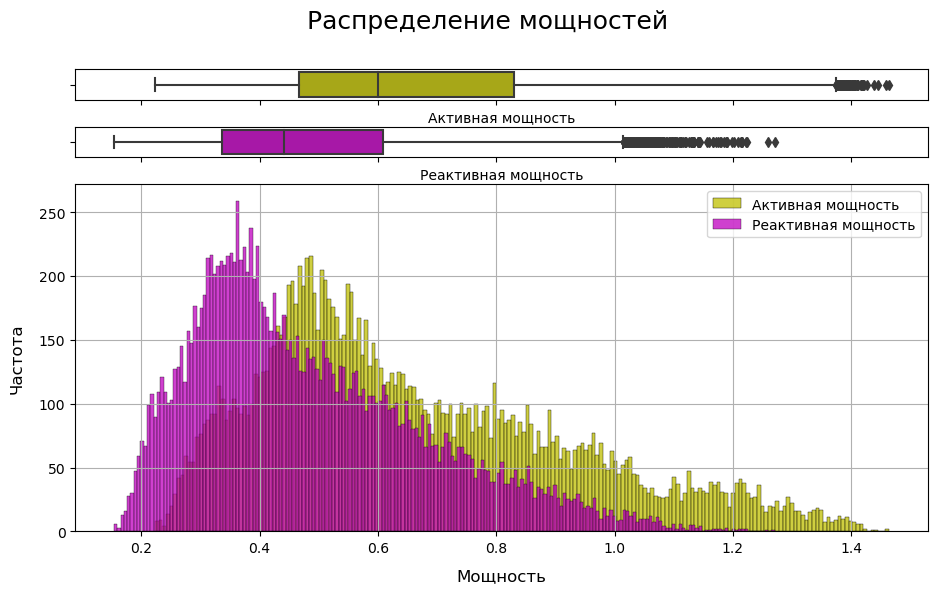

In [11]:
fig, (*box, hist) = plt.subplots(nrows=3, 
                                sharex=True, 
                                figsize=(11, 6), 
                                gridspec_kw={'height_ratios': [0.7, 0.7, 8]})
    
color_shuffle = shuffle(COLOR)
tmp_col = data_arc[data_arc['Реактивная мощность'] > 0].iloc[:,-2:]

for n, i in enumerate(tmp_col.columns):
    
    sns.histplot(data=tmp_col, ax=hist, x=i, bins=200,                  
                 color=color_shuffle[n])
    
    sns.boxplot(data=tmp_col, ax=box[n], x=i,
                color=color_shuffle[n])

plt.suptitle('Распределение мощностей', fontsize=18)
plt.xlabel('Мощность', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.tick_params(labelsize=10)
plt.grid('on')
hist.legend(tmp_col, fontsize=10, handlelength=2)
plt.show;

**Вывод:**  

Предварительный обзор `data_arc_new` показал, что:

- размер датасета 14876 х 5;
- пропусков нет;
- явных дубликатов нет;
- имеется время начала и завершения операции нагрева;
- имеется значения выделенной активной и реактивной мощности при нагреве;
- имеются аномалии в значениях реактивной мощности;
- распределение мощностей близкое к нормальному с большим смещением вправо.

### Предобработка данных

План предобработки:

- переименовать столбцы, используя стиль snake case;
- привести тип данных столбцов со временем к date_time;
- удалить отрицательные значения реактивной мощности;
- удалить ключи с единичным замером;
- вычислить полную мощность;
- вычислить значение энергии;
- агрегировать значения мощностей по ключу. 

Изменеие названий столбцов и типа данных:

In [12]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой': 'heating_start',
                                    'Конец нагрева дугой': 'heating_end',
                                    'Активная мощность': 'active_power', 
                                    'Реактивная мощность': 'reactive_power'})

for col in ['heating_start', 'heating_end']:
    data_arc[col] = pd.to_datetime(data_arc[col])
    
data_arc.info()    #check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   heating_start   14876 non-null  datetime64[ns]
 2   heating_end     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Удаляем отрицательные значения реактивной мощности:

In [13]:
data_arc = data_arc[data_arc['reactive_power'] >= 0]

Удаление ключей с 1 записью:

In [14]:
data_arc = del_single_key(data_arc)

Удалено объектов: 39


2699    2
1986    2
1977    2
566     2
2474    2
Name: key, dtype: int64

Т.к. в датасете имеется время начала и окончания операции, то можно выделить дополнительный признак `heating_time` показывающий время операции нагрева в секундах:

In [15]:
data_arc['heating_time'] = (data_arc['heating_end'] - data_arc['heating_start']).dt.total_seconds()

*Активная мощность (P)* — это часть мощности, связанная непосредственно с трансформацией в какой-либо другой вид энергии.  
*Реактивная мощность (Q)* – это та часть мощности, которая вернется в систему обратно.  
*Полная мощность (S)* - суммарное значение активной и реактивной мощности. Вычесляется по формуле:

$$
S = \sqrt{P^2 + Q^2}
$$

На основании вышесказанного выделяем новый признак `full_power` - значение полной мощности. Активную и реактивную мощность удаляем для исключения коллениарности.

In [16]:
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)
data_arc = data_arc.drop(['active_power', 'reactive_power'], axis=1)

Теперь, с учетом того, что у нас есть значения полной мощности и времени операции, можно выделить дополнительный признак - `energy`, показывающий совершенную работу. Расчитывается по формуле:

$$
E = \frac{S} {\Delta t}
$$

In [17]:
data_arc['energy'] = data_arc['full_power'] / data_arc['heating_time']
data_arc.sample(3)

,key,heating_start,heating_end,heating_time,full_power,energy
14147,3075,2019-09-01 00:55:26,2019-09-01 00:57:55,149.0,0.503833,0.003381
251,53,2019-05-05 13:38:34,2019-05-05 13:41:37,183.0,0.979200,0.005351
13617,2953,2019-08-27 17:03:54,2019-08-27 17:07:51,237.0,1.114889,0.004704


Агрегируем значения мощностей по ключу. В качестве агрегирующей функции используем "сумму":

In [18]:
# median, mean хуже
data_arc_agg = data_arc.groupby('key').agg(np.sum)
data_arc_agg.sample(5)     #check

C:\Users\Admin\AppData\Local\Temp\ipykernel_19576\3361134990.py:2: FutureWarning: The operation <function sum at 0x00000201CD1D00E0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  data_arc_agg = data_arc.groupby('key').agg(np.sum)


,heating_time,full_power,energy
key,,,
811,1477.0,5.270071,0.025548
2577,636.0,2.537237,0.017657
1002,539.0,1.751419,0.009806
1231,963.0,5.308407,0.040419
1110,657.0,4.342654,0.032137


Теперь рассмотрим датасет после обработки:

In [19]:
pass_value_barh(data_arc_agg) 
print()
data_arc_agg.info()
display(data_arc_agg.describe().round(2))

Пропусков нет 😎

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3175 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   heating_time  3175 non-null   float64
 1   full_power    3175 non-null   float64
 2   energy        3175 non-null   float64
dtypes: float64(3)
memory usage: 99.2 KB


,heating_time,full_power,energy
count,3175.00,3175.00,3175.00
mean,802.55,3.85,0.03
std,326.49,1.47,0.02
min,119.00,0.80,0.00
25%,578.00,2.82,0.02
50%,776.00,3.72,0.03
75%,987.00,4.71,0.04
max,4189.00,15.29,0.24


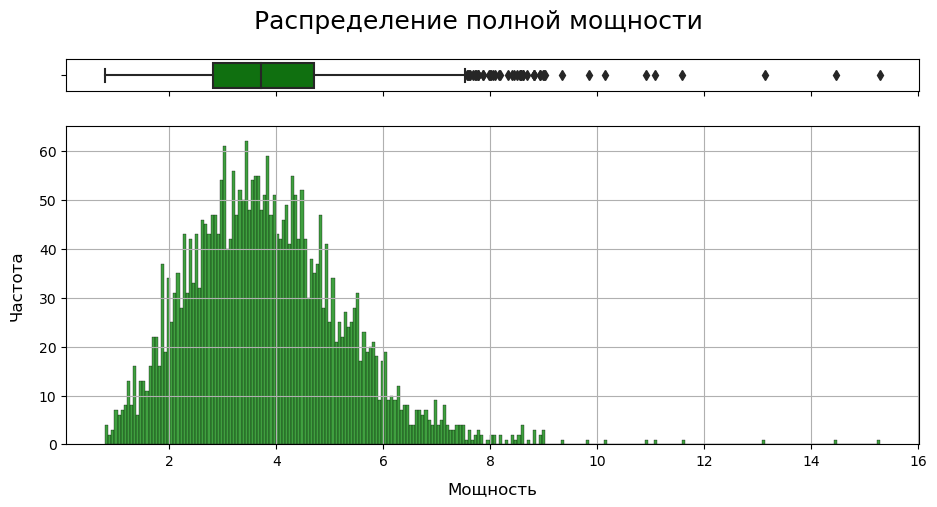

In [20]:
fig, (box, hist) = plt.subplots(nrows=2, 
                                sharex=True, 
                                figsize=(11, 5), 
                                gridspec_kw={'height_ratios': [0.8, 8]})
    
color = random.choice(COLOR)

sns.histplot(data=data_arc_agg, ax=hist, bins=250, 
             x='full_power', color=color)

sns.boxplot(data=data_arc_agg, ax=box, x='full_power',
            color=color).set_xlabel('')

plt.suptitle('Распределение полной мощности', fontsize=18)
plt.xlabel('Мощность', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.tick_params(labelsize=10)
plt.grid('on')
plt.show;


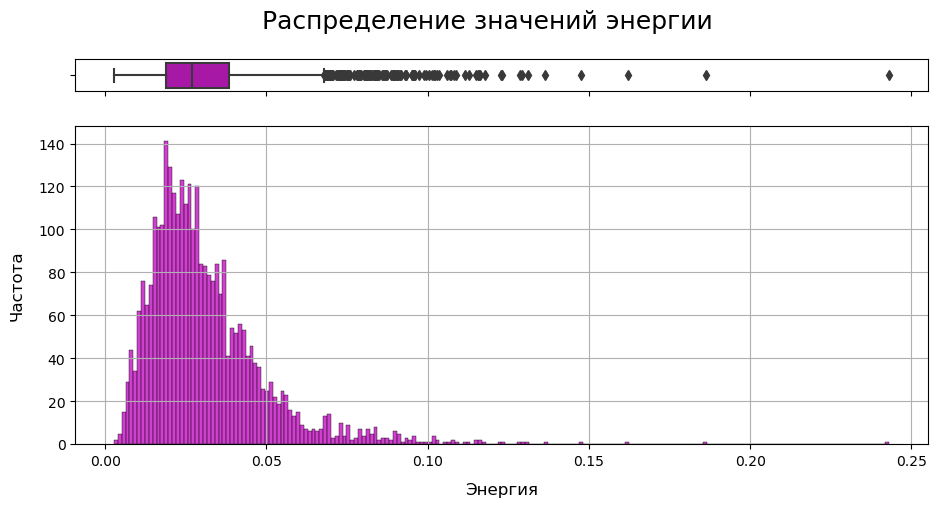

In [21]:
fig, (box, hist) = plt.subplots(nrows=2, 
                                sharex=True, 
                                figsize=(11, 5), 
                                gridspec_kw={'height_ratios': [0.8, 8]})
    
color = random.choice(COLOR)

sns.histplot(data=data_arc_agg, ax=hist, bins=200, 
             x='energy', color=color)

sns.boxplot(data=data_arc_agg, ax=box, x='energy',
            color=color).set_xlabel('')

plt.suptitle('Распределение значений энергии', fontsize=18)
plt.xlabel('Энергия', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.tick_params(labelsize=10)
plt.grid('on')
plt.show;


**Вывод:**  

В результате предобработки датасета `data_arc_new`:

- итоговый размер датасета - 14836 х 5;
- названия столбцов изменены;
- данные не содержат пропусков и дубликатов;
- была удалена 1 аномальная запись;
- были удалены 39 записей с ключами с единственным замером;
- были выделены 2 новых признака:
    - полная мощность
    - энергия
- данные сагрегированы по ключу в роли индекса.

## 2.3 data_bulk_new

### Загрузка и обзор данных

данные о подаче сыпучих материалов (объём)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00



Кол-во явных дубликатов: 0


Доля пропусков: 71.46%


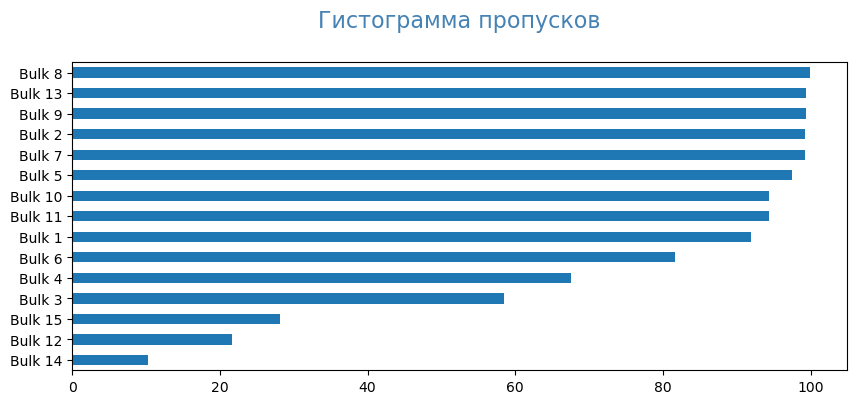

In [22]:
data_bulk = df_eda('data_bulk_new.csv', figsize=(10, 4))

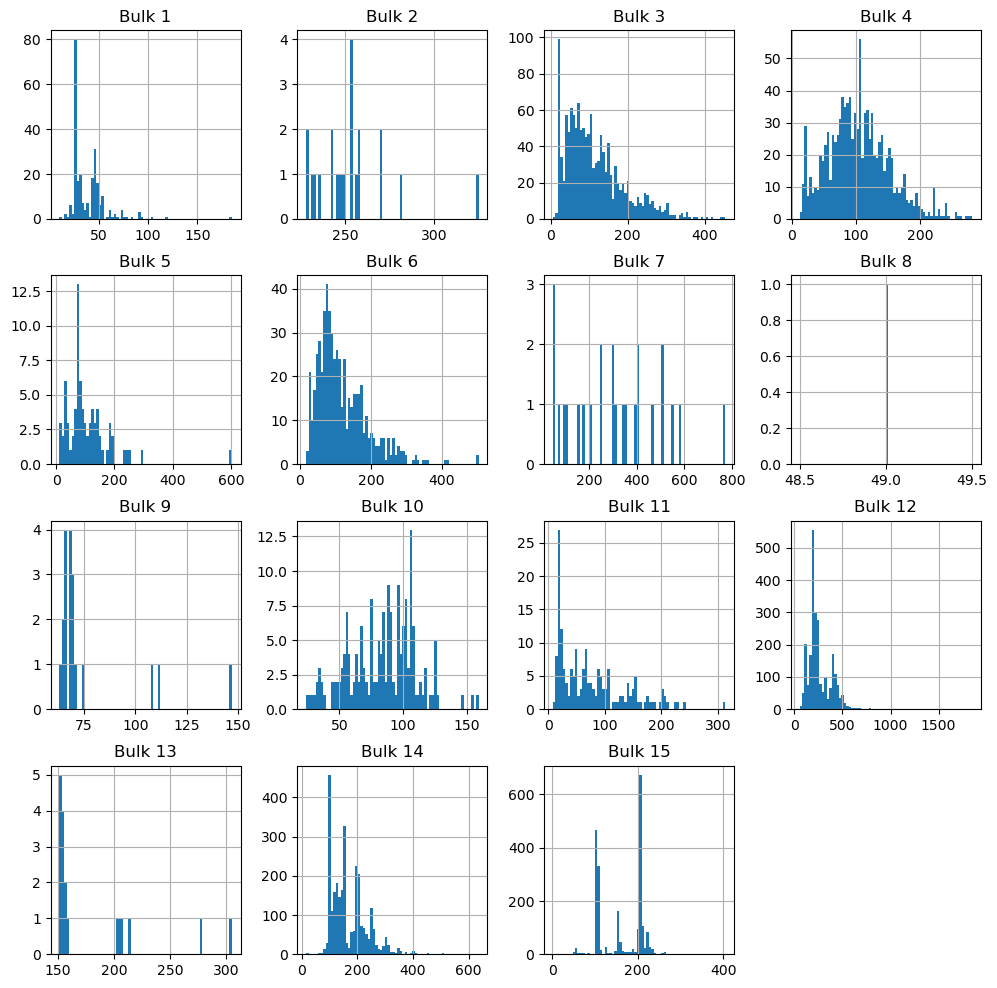

In [23]:
data_bulk.drop('key', axis=1).hist(figsize=(12, 12), bins=70);

**Вывод:**  

Предварительный обзор `data_bulk_new` показал, что:

- размер датасета 3129 х 16;
- имеется 71,46% пропусков;
- явных дубликатов нет;
- тип данных признаков - числовой вещественный, ключей - числовой целочисленный.

### Предобработка данных

План предобработки:

- приведение названий столбцов к snake_case в нижем регистре;
- обработка пропусков;
- обрбаотка аномалий;
- агрегация;
- установка ключа в роли индекса.

Изменяем навзания столбцов через list comprehension:

In [24]:
data_bulk.columns = [i.lower().replace(' ', '_') for i in data_bulk.columns]
data_bulk.columns    #check

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

В данных наблюдается большое кол-во пропусков. В данном случае они означают, что материал не добавлялся, поэтому можно заменить их на значение 0:

In [25]:
data_bulk = data_bulk.fillna(0)

pass_value_barh(data_bulk)     #check

Пропусков нет 😎


Информации о том, какой объем сыпучих материалов является выбросом у нас нет, поэтому аномалии в данных почистить не удастся.

Проверяем все ли ключи уникальны:

In [26]:
data_bulk['key'].nunique() == len(data_bulk)

True

Все ключи уникальны, значит агрегация не требуется. Установим их в качестве индекса:

In [27]:
data_bulk = data_bulk.set_index('key')
data_bulk.sample(2)     #check

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1019,0.0,0.0,154.0,0.0,0.0,234.0,0.0,0.0,0.0,0.0,106.0,138.0,0.0,201.0,102.0
826,0.0,0.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0


Обзор данных после обработки:

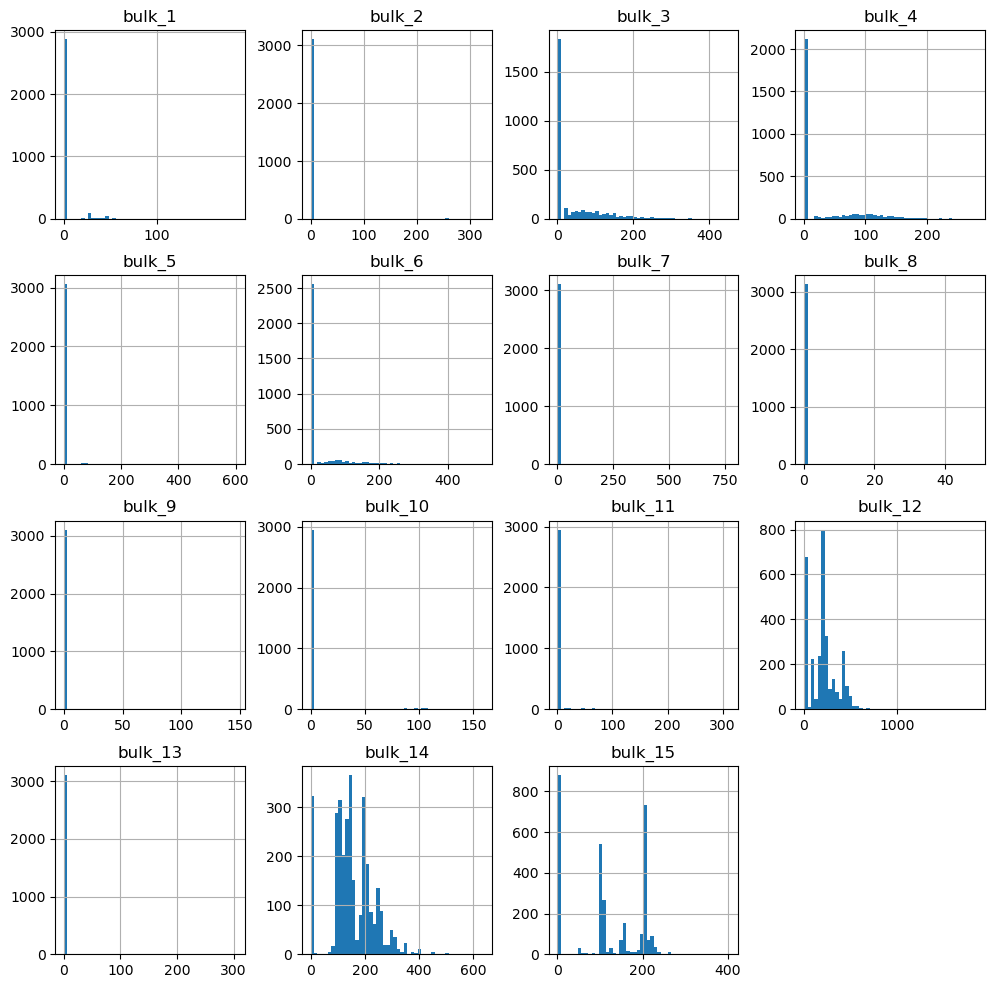

In [28]:
data_bulk.hist(figsize=(12, 12), bins=50);

**Вывод:**  

В результате предобработки датасета `data_bulk_new`:

- итоговый размер датасета не изменился - 3129 х 6;
- названия столбцов изменены;
- все пропуски были заменены на 0;
- данные не содержат явных дубликатов;
- значения ключей уникальны;
- ключ установлен в качестве индекса.

## 2.4 data_bulk_time_new

### Загрузка и обзор данных

данные о подаче сыпучих материалов (время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key
count,3129.00
mean,1624.38
std,933.34
min,1.00
25%,816.00
50%,1622.00
75%,2431.00
max,3241.00



Кол-во явных дубликатов: 0


Доля пропусков: 71.46%


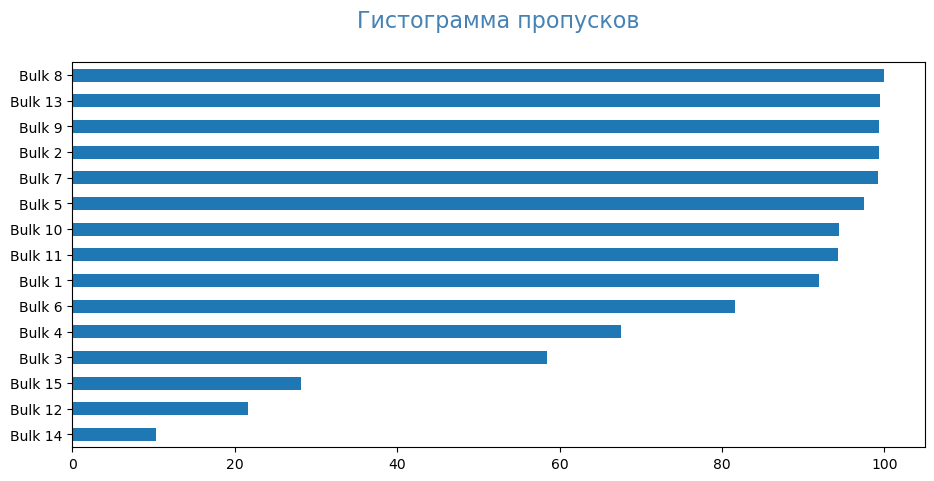

In [29]:
data_bulk_time = df_eda('data_bulk_time_new.csv')

**Вывод:**  

Предварительный обзор `data_bulk_time_new` показал, что:

- размер датасета 3129 х 16;
- имеется 71,46% пропусков;
- явных дубликатов нет;
- тип данных признаков - числовой вещественный, ключей - числовой целочисленный.
> Примечание:
Предобработка в данном случае не требуется. Датасет использоваться для обучения моделей не будет.

## 2.5 data_wire_new

### Загрузка и обзор данных

данные о проволочных материалах (объём)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05



Кол-во явных дубликатов: 0


Доля пропусков: 75.90%


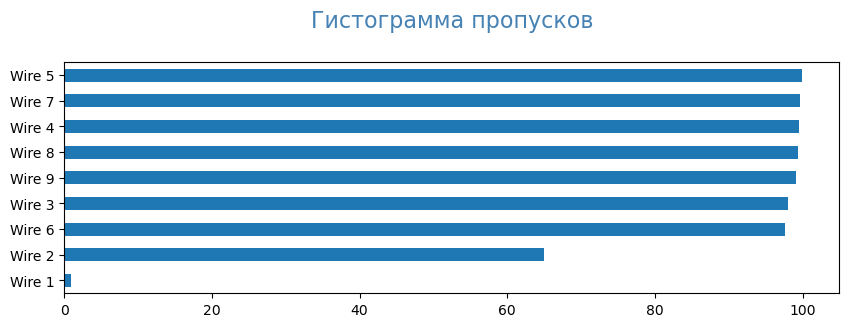

In [30]:
data_wire = df_eda('data_wire_new.csv', figsize=(10, 3))

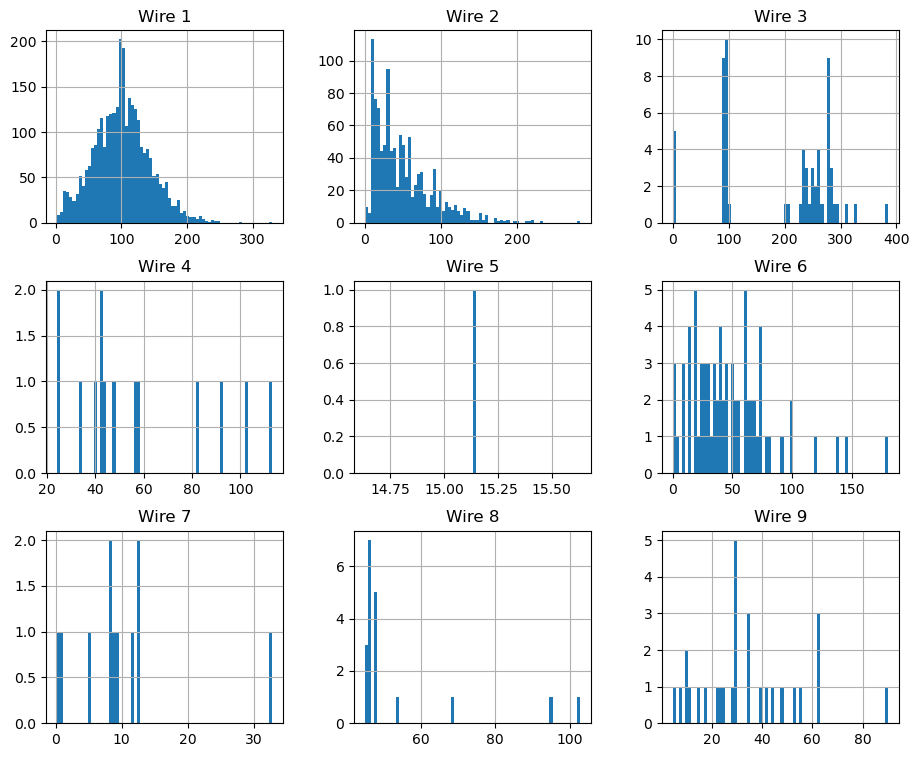

In [31]:
data_wire.drop('key', axis=1).hist(figsize=(11, 9), bins=70);

**Вывод:**  

Предварительный обзор `data_wire_new` показал, что:

- размер датасета 3081 х 10;
- имеется 75,9% пропусков;
- явных дубликатов нет;
- тип данных признаков - числовой вещественный, ключей - числовой целочисленный.

### Предобработка данных

План предобработки:

- приведение названий столбцов к snake_case в нижем регистре;
- обработка пропусков;
- обрбаотка аномалий;
- агрегация;
- установка ключа в роли индекса.

Изменяем навзания столбцов через list comprehension:

In [32]:
data_wire.columns = [i.lower().replace(' ', '_') for i in data_wire.columns]
data_wire.columns     #check

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Наблюдается большое кол-во пропусков. В данном случае они означают, что материал не добавлялся, поэтому можно заменить их на значение 0:

In [33]:
data_wire = data_wire.fillna(0)

pass_value_barh(data_wire)     #check

Пропусков нет 😎


Информации о том, какой объем проволочных материалов является выбросом у нас нет, поэтому аномалии в данных почистить не удастся.

Проверяем все ли ключи уникальны:

In [34]:
data_wire['key'].nunique() == len(data_wire)

True

Все ключи уникальны, значит агрегация не требуется. Установим их в качестве индекса:

In [35]:
data_wire = data_wire.set_index('key')
data_wire.sample(2)     #check

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
2348,80.065437,45.119358,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2123,115.184166,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обзор данных после обработки:

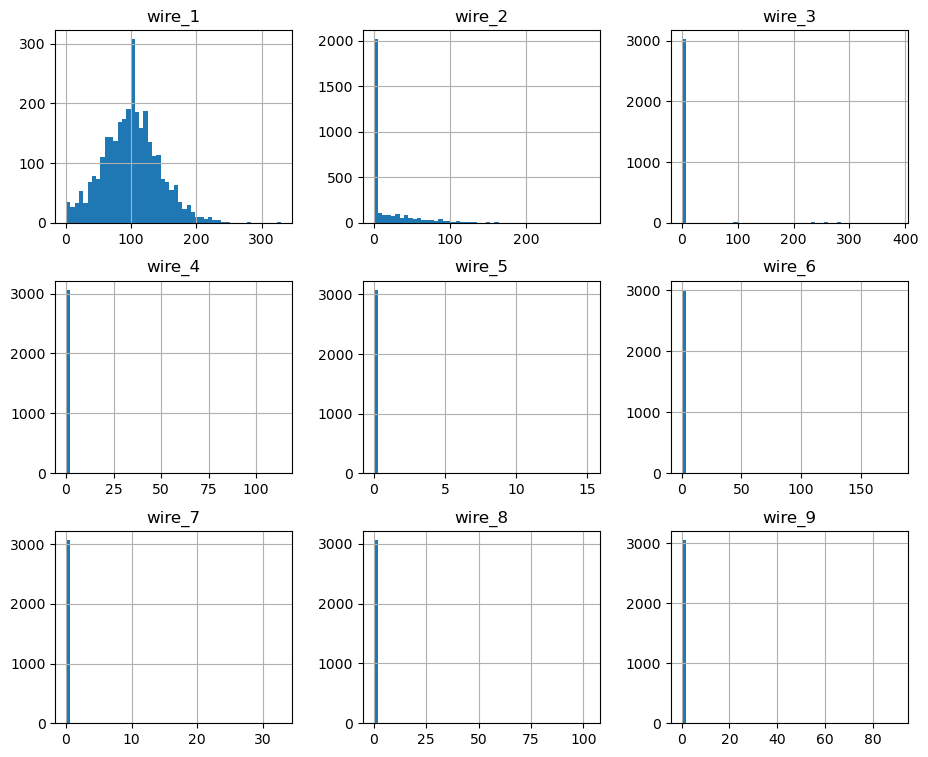

In [36]:
data_wire.hist(figsize=(11, 9), bins=50);

**Вывод:**  

В результате предобработки датасета `data_wire_new`:

- итоговый размер датасета не изменился - 3081 х 10;
- названия столбцов изменены;
- все пропуски были заменены на 0;
- данные не содержат явных дубликатов;
- значения ключей уникальны;
- ключ установлен в качестве индекса.

## 2.6 data_wire_time_new

### Загрузка и обзор данных

данные о проволочных материалах (время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.00
mean,1623.43
std,933.00
min,1.00
25%,823.00
50%,1619.00
75%,2434.00
max,3241.00



Кол-во явных дубликатов: 0


Доля пропусков: 75.90%


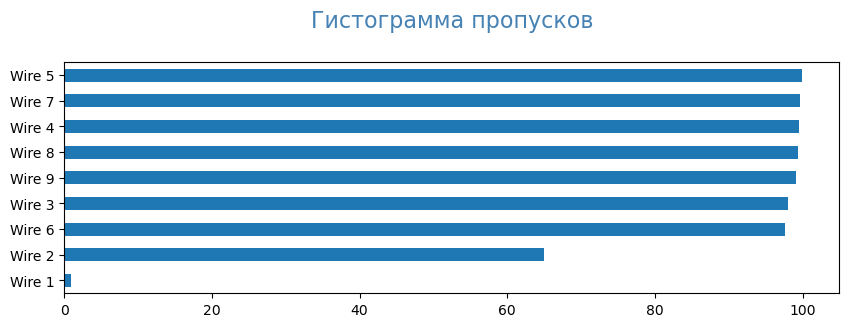

In [37]:
data_wire_time = df_eda('data_wire_time_new.csv', figsize=(10, 3))

**Вывод:**  

Предварительный обзор `data_wire_time_new` показал, что:

- размер датасета 3081 х 10;
- имеется 75,9% пропусков;
- явных дубликатов нет;
- тип данных признаков - объектовый, ключей - числовой целочисленный.

> Примечание:
Предобработка в данном случае не требуется. Датасет использоваться для обучения моделей не будет.

## 2.7 data_gas_new

### Загрузка и обзор данных

In [38]:
data_gas = df_eda('data_gas_new.csv')

данные о продувке сплава газом

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
max,3241.00,78.00



Кол-во явных дубликатов: 0

Пропусков нет 😎


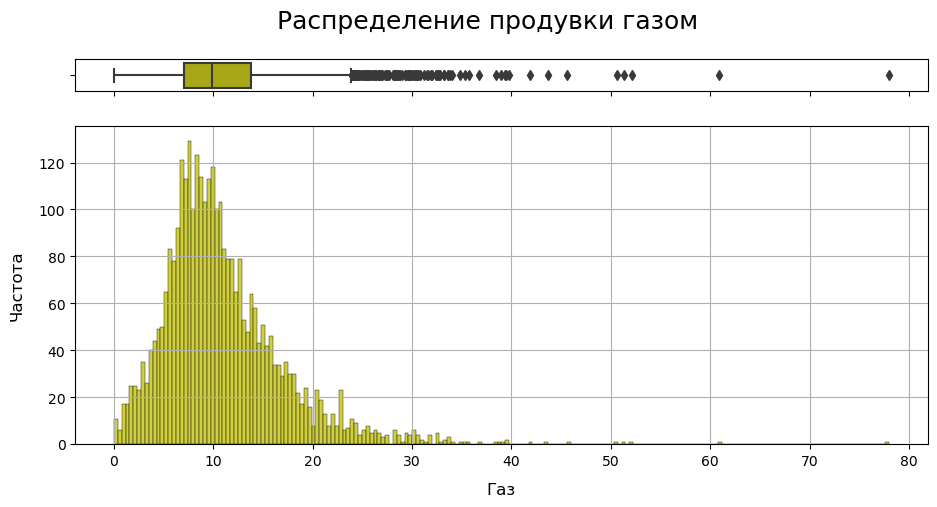

In [39]:
fig, (box, hist) = plt.subplots(nrows=2, 
                                sharex=True, 
                                figsize=(11, 5), 
                                gridspec_kw={'height_ratios': [0.8, 8]})
    
color = random.choice(COLOR)

sns.histplot(data=data_gas, ax=hist, bins=200, 
             x='Газ 1', color=color)

sns.boxplot(data=data_gas, ax=box, x='Газ 1',
            color=color).set_xlabel('')

plt.suptitle('Распределение продувки газом', fontsize=18)
plt.xlabel('Газ', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.tick_params(labelsize=10)
plt.grid('on')
plt.show;


**Вывод:**  

Предварительный обзор `data_gas_new` показал, что:

- размер датасета 3239 х 2;
- пропусков нет;
- явных дубликатов нет;
- тип данных - числовой вещественный;
- распределение близко к нормальному;
- имеется небольшое кол-во выбросов в правой части, но являются ли они аномалиями - неизвестно.

### Предобработка данных

План предобработки:

- приведение названий столбцов к snake_case в нижем регистре;
- проверка уникальности ключей;
- установка ключа в роли индекса.

Изменяем навзания столбцов:

In [40]:
data_gas.rename(columns={'Газ 1': 'gas_1'}, inplace=True)
data_gas.columns     #check

Index(['key', 'gas_1'], dtype='object')

Проверяем все ли ключи уникальны:

In [41]:
data_gas['key'].nunique() == len(data_gas)

True

Все ключи уникальны, значит агрегация не требуется. Установим их в качестве индекса:

In [42]:
data_gas = data_gas.set_index('key')
data_gas.sample(2)     #check

,gas_1
key,
2317,10.286562
2545,13.771959


**Вывод:**  

В результате предобработки датасета `data_gas_new`:

- итоговый размер датасета не изменился - 3239 х 2;
- названия столбцов изменены;
- данные не содержат пропусков и явных дубликатов;
- значения ключей уникальны;
- ключ установлен в качестве индекса.

## 2.8 data_temp_new

### Загрузка и обзор данных

 (ЦЕЛЕВОЙ ПРИЗНАК) результаты измерения температуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Температура
count,18092.00,14665.00
mean,1616.46,1590.72
std,934.64,20.39
min,1.00,1191.00
25%,807.75,1580.00
50%,1618.00,1590.00
75%,2429.00,1599.00
max,3241.00,1705.00



Кол-во явных дубликатов: 0


Доля пропусков: 6.31%


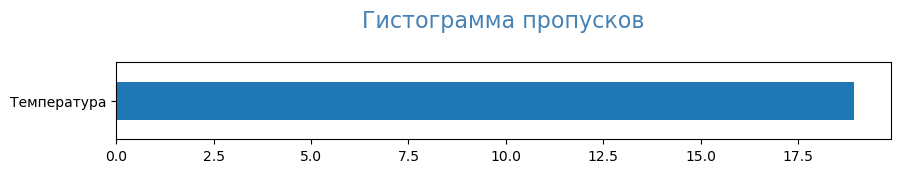

In [43]:
data_temp = df_eda('data_temp_new.csv', figsize=(10, 1))

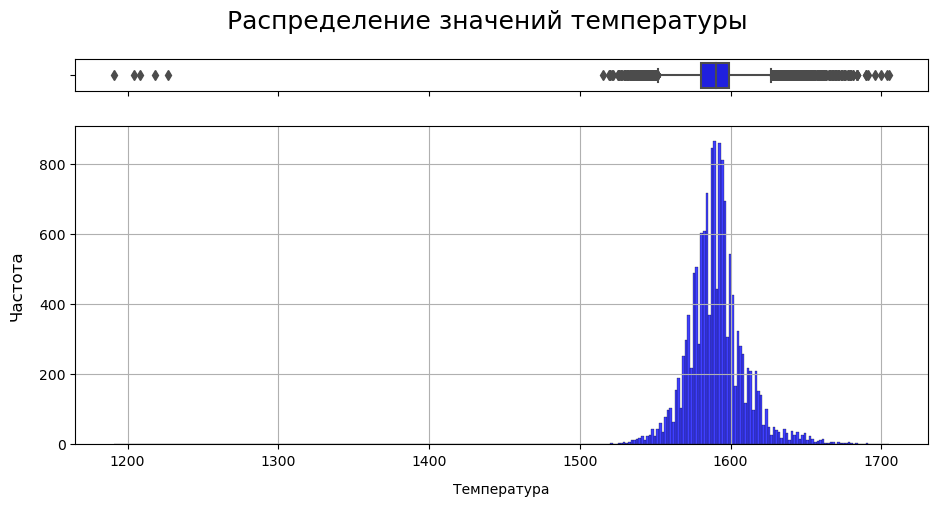

In [44]:
fig, (box, hist) = plt.subplots(nrows=2, 
                                sharex=True, 
                                figsize=(11, 5), 
                                gridspec_kw={'height_ratios': [0.8, 8]})
    
color = random.choice(COLOR)

sns.histplot(data=data_temp, ax=hist, bins=300, 
             x='Температура', color=color)

sns.boxplot(data=data_temp, ax=box, x='Температура',
            color=color).set_xlabel('')

plt.suptitle('Распределение значений температуры', fontsize=18)
plt.xlabel('Температура', fontsize=10, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.tick_params(labelsize=10)
plt.grid('on')
plt.show;


**Вывод:**  

Предварительный обзор `data_temp_new` показал, что:

- размер датасета 18092 х 3;
- имеется 6,31% пропусков;
- явных дубликатов нет;
- распределение значений температур близкое к нормальному;
- имеется некоторое кол-во выбросов в зоне высоких температур;
- среднее значение находится в районе 1590 градусов;
- имеются аномалии температуры ниже 1500 градусов;
- тип данных признаков - числовой вещественный, ключей - числовой целочисленный.

### Предобработка данных

План предобработки:

- переименовать столбцы, используя стиль Snake case;
- изменить тип данных столбца `Время замера` на временной;
- удалить пропуски, т.к. их невозможно восстановить;
- удалить целиком ключи, значение температур в которых ниже температуры плавления стали. В данном случае было согласовано значение 1500;
- удалить ключи с единичным замером;
- оставить только записи с первой и последней по времени измеренной температурой. 

Изменеие названий столбцов и типа данных:

In [45]:
data_temp = data_temp.rename(columns={'Время замера': 'time', 'Температура': 'temp'})
data_temp['time'] = pd.to_datetime(data_temp['time'])
data_temp.info()    #check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18092 non-null  int64         
 1   time    18092 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Удаление пропусков:

In [46]:
data_temp = data_temp.dropna()

pass_value_barh(data_temp)     #check

Пропусков нет 😎


Удаление значений температур ниже 1500:

In [47]:
key_tmp = data_temp.query('temp < 1500')['key'].unique()
data_temp = data_temp.query('key not in @key_tmp')

Удаление ключей с 1 записью:

In [48]:
data_temp = del_single_key(data_temp)

Удалено объектов: 740


1766    2
246     2
1268    2
1974    2
556     2
Name: key, dtype: int64

Создадим новый датасет с одной записью для каждого ключа, добавив значения первого и последнего замеров. А так же на основании разниц по времени создаем дополнительный признак `time_delta`:

In [49]:
columns=['temp_start', 'temp_end', 'time_delta']
data_temp_full = pd.DataFrame(data=None, index=None, columns=columns)

for key in tqdm(data_temp['key'].unique()):
    tmp = data_temp[data_temp['key'] == key].reset_index(drop=True)
    time_min = tmp['time'].min()
    time_max = tmp['time'].max()
    
    data_temp_full = pd.concat([data_temp_full, 
                                pd.DataFrame([[tmp[tmp['time'] == time_min]['temp'].iloc[0],
                                               tmp[tmp['time'] == time_max]['temp'].iloc[0],
                                               (time_max - time_min).total_seconds()
                                              ]], index=[key], columns=columns)
                               ])

100%|█████████████████████████████████████████████████████████████████████████████| 2471/2471 [00:04<00:00, 605.27it/s]


Теперь посмотрим на датасет после обработки:

In [50]:
pass_value_barh(data_temp_full) 
print()
data_temp_full.info()
display(data_temp_full.describe().round(2))

Пропусков нет 😎

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_start  2471 non-null   float64
 1   temp_end    2471 non-null   float64
 2   time_delta  2471 non-null   float64
dtypes: float64(3)
memory usage: 77.2 KB


,temp_start,temp_end,time_delta
count,2471.00,2471.00,2471.00
mean,1589.01,1595.34,2281.32
std,25.00,16.04,1374.34
min,1519.00,1541.00,339.00
25%,1572.00,1587.00,1544.50
50%,1588.00,1593.00,2007.00
75%,1605.00,1599.00,2739.50
max,1679.00,1700.00,23674.00


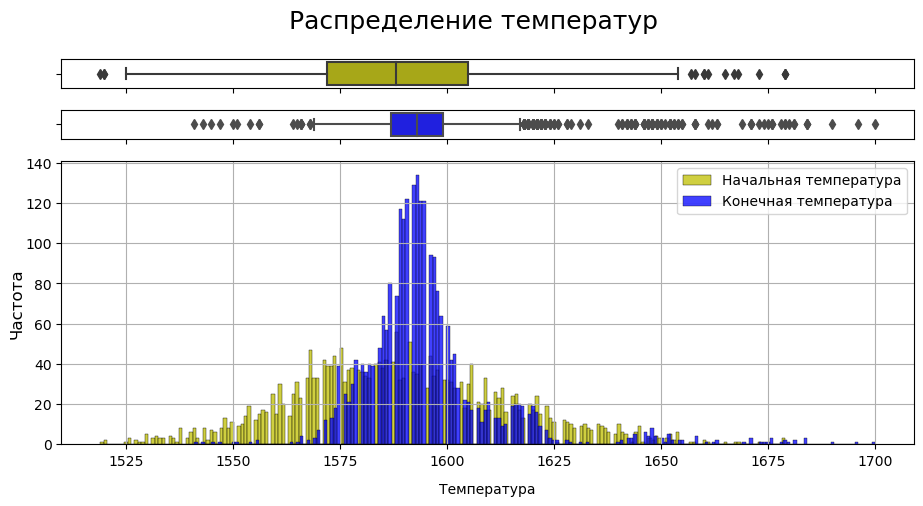

In [51]:
fig, (*box, hist) = plt.subplots(nrows=3, 
                                sharex=True, 
                                figsize=(11, 5), 
                                gridspec_kw={'height_ratios': [0.8, 0.8, 8]})
    
color_shuffle = shuffle(COLOR)

for n, i in enumerate(['temp_start', 'temp_end']):
    
    sns.histplot(data=data_temp_full, ax=hist, x=i, bins=200,                  
                 color=color_shuffle[n])

    sns.boxplot(data=data_temp_full, ax=box[n], x=i,
                color=color_shuffle[n]).set_xlabel('')

plt.suptitle('Распределение температур', fontsize=18)
plt.xlabel('Температура', fontsize=10, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=0)
plt.tick_params(labelsize=10)
plt.grid('on')
hist.legend(['Начальная температура', 'Конечная температура'], fontsize=10, handlelength=2)
plt.show;

**Вывод:**

В результате предобработки датасета `data_temp_new` был создан новый датасет, в котором:

- выделен целевой признак - `time_end`;
- удалены ключи с единичным замером в исходном датасете;
- оставлены только единичные записи по каждому ключу;
- кол-во строк сократилось с 18092 до 2471;
- удалены все пропуски;
- объекты проверены на дубликаты;
- аномалии и температуры ниже 1500 градусов удалены;
- распределение признаков близкое к нормальному;
- имеется некоторое кол-во выбросов в зоне высоких температур;
- конечное значение (целевой признак) имеет меньший разброс значений;
- переименованы столбцы;
- ключ установлен в качестве индекса;
- тип данных признаков - числовой вещественный, ключей - числовой целочисленный.

## 2.9 Вывод по разделу

В данном разделе были выполнены исследовательский обзор и предварительная обработка данных, в ходе которых:

- датасеты были загружены без ошибок;
- пропуски были удалены или заменены;
- обработаны аномалии;
- объекты проверены на явные дубликаты;
- ключи по которым есть только 1 запись были удалены;
- оставлены только уникальные значения ключей;
- данные по ключам сагрегированы;
- ключи установлены в роли индексов;
- имена столбцов приведены в соответствии со стандартом;
- выделен целевой признак - конечная температура;
- выделены дополнительные признаки - начальная температура, полная мощность и работа;

Более подробные выводы по каждому разделу описаны непосредственно в самих разделах.


# 3 Подготовка данных для обучения  

## 3.1 Объединение датасетов  

Объединяем все предобработанные датасеты, кроме `data_bulk_time` и `data_wire_time`, методом пересечения. При этом в выборку попадут только те объекты, ключи которых имеются одновременно во всех датасетах. Это нужно для того, чтобы не получить лишние пропуски.

In [52]:
print(
    'Исходные размеры выборок:\n',
    f'data_arc_agg : {data_arc_agg.shape[0]}',
    f'data_bulk : {data_bulk.shape[0]}',
    f'data_gas : {data_gas.shape[0]}',
    f'data_wire : {data_wire.shape[0]}',
    f'data_temp_full : {data_temp_full.shape[0]}',
    sep='\n'
)

Исходные размеры выборок:

data_arc_agg : 3175
data_bulk : 3129
data_gas : 3239
data_wire : 3081
data_temp_full : 2471


In [53]:
data_total = pd.concat([data_arc_agg, data_bulk, data_gas, 
                        data_wire, data_temp_full], join='inner', axis=1)

pass_value_barh(data_total, figsize=(10, 4)) 
print()
data_total.info()
display(data_total.tail())

Пропусков нет 😎

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2300 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   heating_time  2300 non-null   float64
 1   full_power    2300 non-null   float64
 2   energy        2300 non-null   float64
 3   bulk_1        2300 non-null   float64
 4   bulk_2        2300 non-null   float64
 5   bulk_3        2300 non-null   float64
 6   bulk_4        2300 non-null   float64
 7   bulk_5        2300 non-null   float64
 8   bulk_6        2300 non-null   float64
 9   bulk_7        2300 non-null   float64
 10  bulk_8        2300 non-null   float64
 11  bulk_9        2300 non-null   float64
 12  bulk_10       2300 non-null   float64
 13  bulk_11       2300 non-null   float64
 14  bulk_12       2300 non-null   float64
 15  bulk_13       2300 non-null   float64
 16  bulk_14       2300 non-null   float64
 17  bulk_15       2300 non-null   float64
 18  gas_1      

,heating_time,full_power,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,temp_start,temp_end,time_delta
2495,723.0,3.868721,0.024329,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,1591.0,1380.0
2496,940.0,5.070316,0.034861,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0,1591.0,1705.0
2497,569.0,4.360918,0.023523,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1589.0,962.0
2498,750.0,3.909917,0.036052,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,1594.0,1520.0
2499,883.0,2.169252,0.011835,0.0,0.0,47.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1569.0,1603.0,1537.0


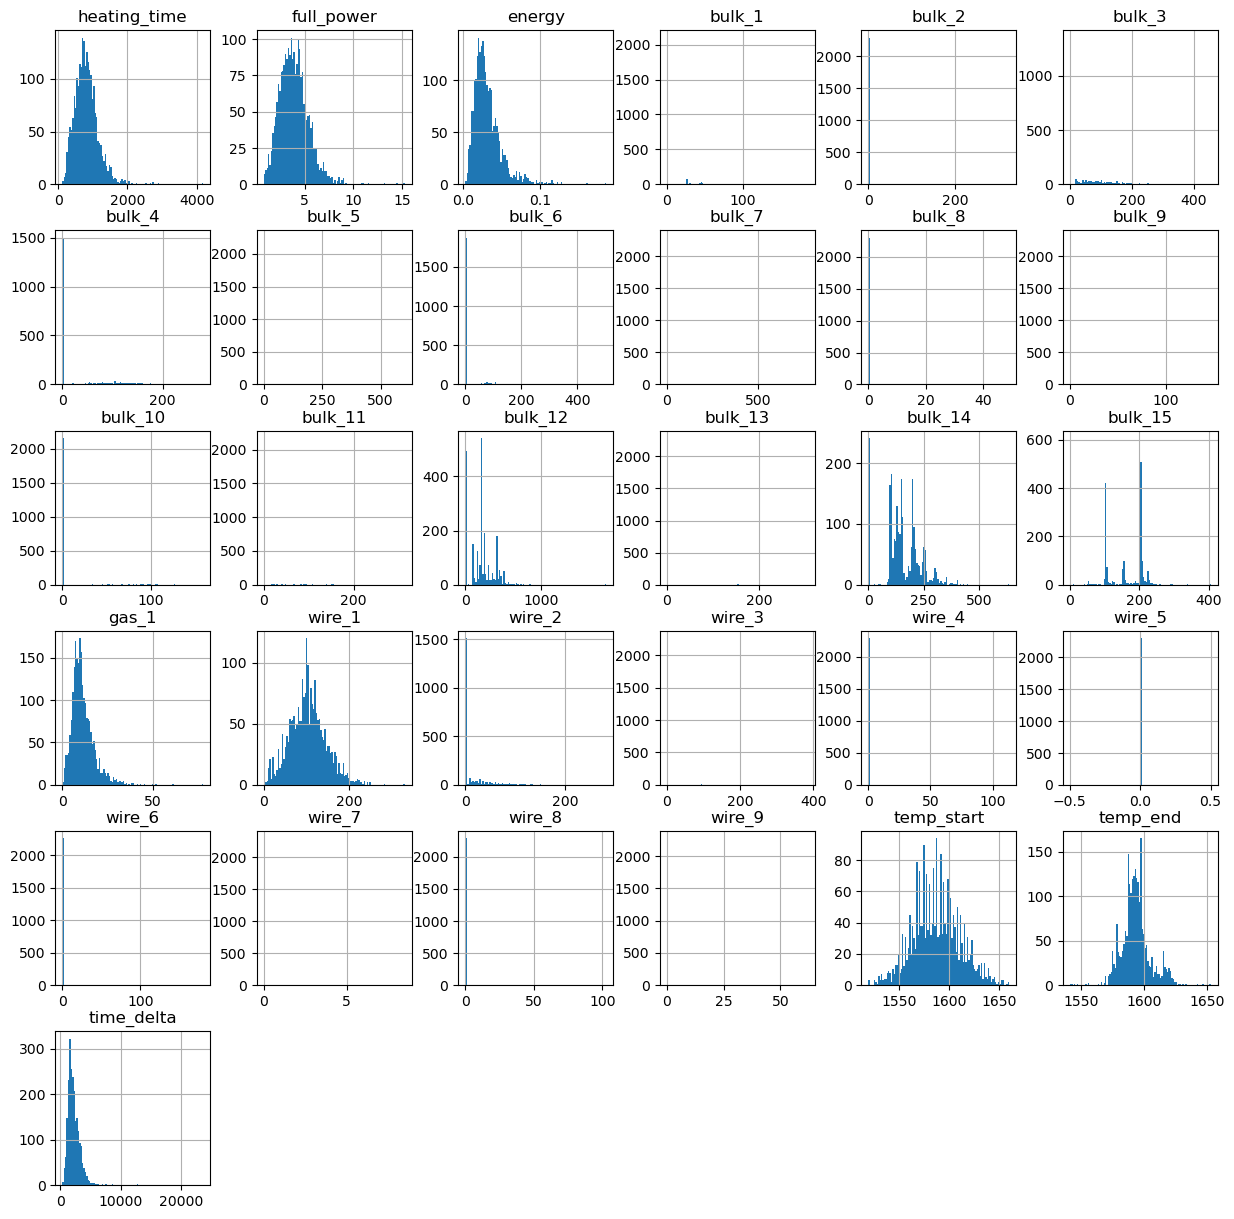

In [54]:
data_total.hist(figsize=(15, 15), bins=100);

## 3.2 Создание тестовой выборки  

In [55]:
(x_train, x_test, 
 y_train, y_test) = ( train_test_split(data_total.drop('temp_end', axis=1), 
                                       data_total['temp_end'], 
                                       test_size=0.25,
                                       shuffle=False,
                                       random_state=RANDOM_STATE) ) 

# check
print('Размер обучающих выборок: ', x_train.shape, y_train.shape)
print('Размер тестовых выборок: ', x_test.shape, y_test.shape)

Размер обучающих выборок:  (1725, 30) (1725,)
Размер тестовых выборок:  (575, 30) (575,)


## 3.3 Предобработка данных

### 3.3.1 Удаление столбцов с нулевыми значениями

In [56]:
tmp = x_train.sum()
x_train = x_train.drop(list(tmp[tmp.values == 0].index), axis=1)
x_train.sample(3)    #check

,heating_time,full_power,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_8,wire_9,temp_start,time_delta
1845,1083.0,3.465841,0.018308,0.0,0.0,0.0,133.0,0.0,0.0,0.0,...,8.325121,114.893997,0.000000,0.0,0.0,0.0,0.0,0.0,1585.0,2168.0
1666,1340.0,5.525678,0.039649,0.0,0.0,36.0,0.0,19.0,165.0,0.0,...,21.026331,85.222801,117.322395,0.0,0.0,0.0,0.0,0.0,1573.0,3902.0
512,1584.0,5.374670,0.025483,0.0,0.0,62.0,0.0,0.0,264.0,0.0,...,10.539055,77.266800,15.200640,0.0,0.0,0.0,0.0,0.0,1520.0,2690.0


### 3.3.2 Построение карты корреляций признаков 

Т.к. я планирую использовать в проекте модель линейной регрессии, то для неё нужно исключить сильно коррелирующие признаки. Хоть это и не повлияет на метрику качества, но позволит интерпретировать веса.

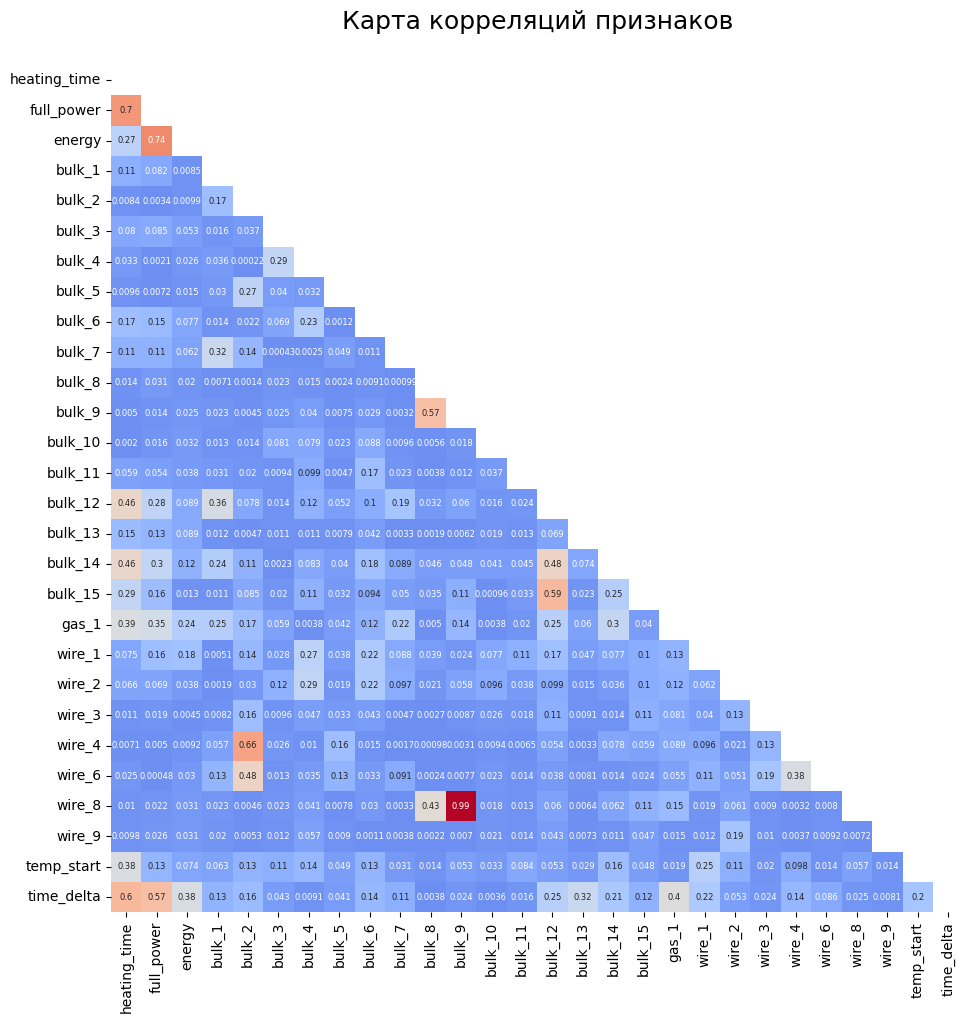

In [57]:
fig = plt.figure(figsize=(11, 11))

sns.heatmap( x_train.corr().abs(), 
             cmap="coolwarm", fmt='.2g', 
             cbar=False,
             center=0.4,
             annot=True, 
             annot_kws={'fontsize': 6},             
             mask=np.triu(x_train.corr()) )

plt.title('Карта корреляций признаков'+ '\n', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)

plt.show()

Исключаям `bulk_9` из признаков из-за высокой корреляции:

In [58]:
x_train = x_train.drop('bulk_9', axis=1)

Приведенный выше метод учитывает только линейные зависимости. Для исследования нелинейных зависимостей воспользуемся библиотекой phik:

interval columns not set, guessing: ['heating_time', 'full_power', 'energy', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_8', 'wire_9', 'temp_start', 'time_delta']


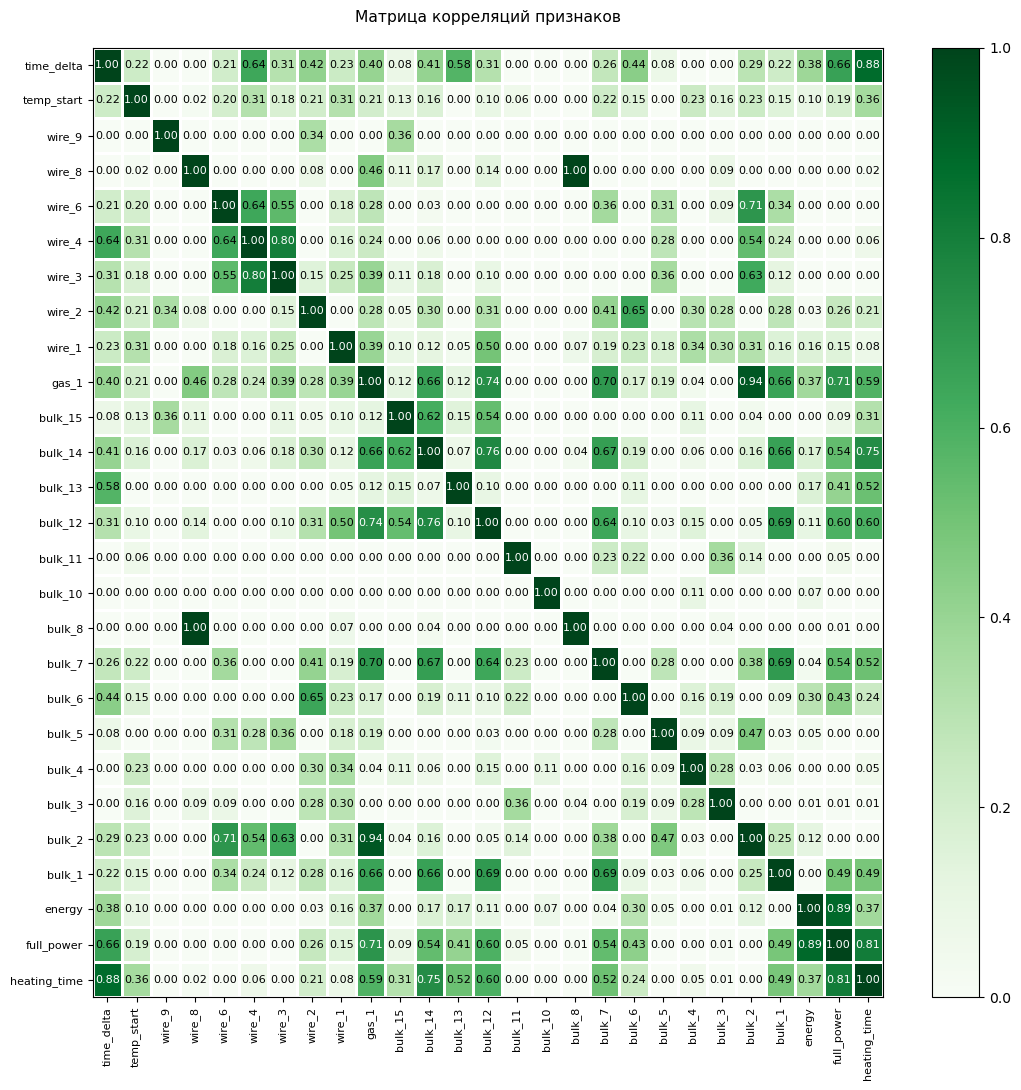

In [59]:
phik_overview = x_train.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title='Матрица корреляций признаков\n', 
                        fontsize_factor=0.8, 
                        figsize=(11, 11))

Исключаям так же `bulk_8` из признаков из-за высокой корреляции:

In [60]:
x_train = x_train.drop('bulk_8', axis=1)

Итоговый список признаков выглядит так:

In [61]:
features = x_train.columns
features

Index(['heating_time', 'full_power', 'energy', 'bulk_1', 'bulk_2', 'bulk_3',
       'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3',
       'wire_4', 'wire_6', 'wire_8', 'wire_9', 'temp_start', 'time_delta'],
      dtype='object')

Теперь необходимо, чтобы фичи тренировочной и тестовой выборок совпадали:

In [62]:
x_test = x_test[features]

### 3.3.3 Поиск и удаление аномалий

Удаляем аномалии, используя метод k-ближайших соседей (KNN). Для этого подключаем подель и обучаем её только на тренировочкной выборке, чтобы не было утечек:

In [63]:
model_knn = KNN(contamination=0.04, n_neighbors=9)
model_knn.fit(x_train)
knn_lst =  model_knn.predict(x_train)

x_train = x_train[knn_lst != 1]
y_train = y_train[knn_lst != 1]

print("Удалено аномалий (KNN): ", knn_lst.sum())

Удалено аномалий (KNN):  62


**Вывод:** 
Удалено около 3,5% аномалий, что совсем не критично, но сказывается на качестве моделей в лучшую сторону.

# 4 Обучение моделей

Создание метрики качества моделей:

In [64]:
mae = make_scorer(mean_absolute_error, greater_is_better=False)

Фнукция обучения и вывода информации:

In [65]:
def model_create(model, params):
    '''Создает и обучает модель перебором параметров. Находит метрику МАЕ'''
    
    mdl = GridSearchCV(model, params, cv=CV, scoring=mae, n_jobs=-1)
    mdl.fit(x_train, y_train)
    score = abs(mdl.best_score_).round(3)                
    print(
        f'\nMAE модели {model.__class__.__name__} = {score}',
        f'Лучшие гиперпараметры:',
        sep='\n\n'
    )
    display(mdl.best_params_)
    return mdl.best_estimator_, score

## 4.1 Линейная регрессия

### 4.1.1 Масштабирование признаков

Масштабирование не повлияет на метрику качеста. Но без масштабирования невозможна интерпретация весов модели. Скейлер обучим только на тренировочной выборке, чтобы избежать утечек:

In [66]:
pd.options.mode.chained_assignment = None     # для исключения предупреждения

scaler = StandardScaler()
scaler.fit(x_train)

x_train_sc = x_train.copy()
x_test_sc = x_test.copy()

x_train_sc[x_train.columns] = scaler.transform(x_train[x_train.columns])
x_test_sc[x_train.columns] = scaler.transform(x_test[x_train.columns])

display(x_train_sc.sample(4), x_test_sc.sample(4))

,heating_time,full_power,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_8,wire_9,temp_start,time_delta
890,0.376885,1.154174,0.857601,-0.302016,0.0,-0.637285,1.322340,-0.107878,-0.379626,-0.032772,...,-0.421455,-0.582079,-0.518636,-0.101343,0.0,-0.084628,-0.077006,-0.092696,-0.726803,-0.197490
864,1.134687,0.583202,-0.121735,-0.302016,0.0,0.089614,-0.631758,-0.107878,-0.379626,-0.032772,...,-0.404438,0.714413,-0.518636,-0.101343,0.0,-0.084628,-0.077006,-0.092696,-1.405630,-0.100355
569,0.104217,-0.532348,-1.096648,-0.302016,0.0,3.195453,-0.631758,-0.107878,-0.379626,-0.032772,...,-0.174082,-1.313009,1.280688,-0.101343,0.0,-0.084628,-0.077006,-0.092696,0.540340,-0.991776
141,-0.621715,-0.644515,-0.442623,-0.302016,0.0,-0.637285,-0.631758,-0.107878,-0.379626,-0.032772,...,0.409861,-0.267658,-0.518636,-0.101343,0.0,7.783588,-0.077006,-0.092696,1.128656,0.020140


,heating_time,full_power,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_8,wire_9,temp_start,time_delta
2191,-0.430494,-0.664729,-0.944778,-0.302016,0.0,-0.637285,2.467846,-0.107878,-0.379626,-0.032772,...,-0.487853,1.466142,-0.518636,-0.101343,0.0,-0.084628,-0.077006,-0.092696,-0.953079,-1.273342
2274,-0.108251,-0.953581,-1.117135,-0.302016,0.0,-0.637285,0.395828,-0.107878,-0.379626,-0.032772,...,-0.152590,2.453945,-0.518636,-0.101343,0.0,-0.084628,-0.077006,-0.092696,1.354932,0.977956
2114,-0.979369,-1.368104,-1.093985,-0.302016,0.0,0.287859,-0.631758,-0.107878,-0.379626,-0.032772,...,0.142874,-1.408776,-0.518636,-0.101343,0.0,6.275406,-0.077006,-0.092696,-0.093232,-0.648733
1972,0.468954,0.044769,-0.373393,-0.302016,0.0,1.768088,-0.631758,-0.107878,1.522518,-0.032772,...,-0.231857,-1.410834,0.681815,-0.101343,0.0,-0.084628,-0.077006,-0.092696,-1.179354,-0.022894


### 4.1.2 Обучение

In [67]:
%%time

model_lr = LinearRegression() 

lr_score = abs(cross_val_score(model_lr, x_train_sc, y_train, 
                           scoring=mae, cv=CV).mean().round(3))  
model_lr.fit(x_train_sc, y_train)

print('\nMAE модели линейной регрессии =', abs(lr_score))   #5.741


MAE модели линейной регрессии = 5.741
CPU times: total: 344 ms
Wall time: 71.8 ms


## 4.2 Случайный лес

In [68]:
%%time

params = { 'n_estimators': range(40, 41),          # 40   (1-100)
           'max_depth': range(6, 7),               # 6    (1-30)
           'min_samples_leaf': range(6, 7),        # 6    (1-20)
           'min_samples_split': range(15, 16),     # 15   (1-30)
           'random_state': [RANDOM_STATE] 
         }


model_rfc, rfc_score = model_create(RandomForestRegressor(), params)   # 6.185


MAE модели RandomForestRegressor = 6.185

Лучшие гиперпараметры:


{'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 15,
 'n_estimators': 40,
 'random_state': 80523}

CPU times: total: 938 ms
Wall time: 890 ms


## 4.3 CatBoost

In [69]:
%%time

params = { 'depth':  range(6, 7),               # 6
           'n_estimators': range(31, 32),       # 31
           'learning_rate': [0.34],             # 0.34               
           'silent': [True],
           'random_seed': [RANDOM_STATE]
        }


model_cat, cat_score = model_create(CatBoostRegressor(), params)   # 5.926


MAE модели CatBoostRegressor = 5.926

Лучшие гиперпараметры:


{'depth': 6,
 'learning_rate': 0.34,
 'n_estimators': 31,
 'random_seed': 80523,
 'silent': True}

CPU times: total: 547 ms
Wall time: 1.57 s


## 4.4 LightGBM

In [70]:
%%time

params = { 'max_depth': range(2, 3),            # 2   (1-60)  
           'n_estimators': range(108, 109),     # 108   (1-1000)       
           'learning_rate': [0.26],             # 0.26 (0.1-0.9)
           'boosting_type': ['gbdt'],       #   gbdt, dart, goss
           'random_state': [RANDOM_STATE]
         }


model_lgbm, lgbm_score = model_create(LGBMRegressor(verbose=-1), params)   # 5.815  


MAE модели LGBMRegressor = 5.815

Лучшие гиперпараметры:


{'boosting_type': 'gbdt',
 'learning_rate': 0.26,
 'max_depth': 2,
 'n_estimators': 108,
 'random_state': 80523}

CPU times: total: 109 ms
Wall time: 1.26 s


## 4.5 Выбор лучшей модели

Сведем все полученые метрики в одну таблицу:

In [71]:
result = pd.DataFrame({'Модель':['LinearRegression'], 'МАЕ': [lr_score]})

for i in ['rfc', 'cat', 'lgbm']:
    tmp = pd.DataFrame([[eval(f'model_{i}.__class__.__name__'), eval(f'{i}_score')]],
                       columns=result.columns)
    result = pd.concat([result, tmp], ignore_index=True)
    
result     #check

,Модель,МАЕ
0,LinearRegression,5.741
1,RandomForestRegressor,6.185
2,CatBoostRegressor,5.926
3,LGBMRegressor,5.815


Добавим в сравнение дополнительную метрику - коээф. детерминации, показывающий долю дисперсии, объясненную моделью.

In [72]:
r2 = make_scorer(r2_score)  # создаем метрику
r2_lst = list()
r2_sc = cross_val_score(model_lr, x_train_sc, y_train, 
                           scoring=r2, cv=CV).mean().round(3)
r2_lst.append(r2_sc)

for i in ['rfc', 'cat', 'lgbm']:
    r2_sc = cross_val_score(eval(f'model_{i}'), x_train, y_train, 
                               scoring=r2, cv=CV).mean().round(3)
    r2_lst.append(r2_sc)

result['R2'] = r2_lst
result

,Модель,МАЕ,R2
0,LinearRegression,5.741,0.506
1,RandomForestRegressor,6.185,0.409
2,CatBoostRegressor,5.926,0.467
3,LGBMRegressor,5.815,0.477


**Вывод:** Лучшая модель по метрикам получаилась модель линейной регрессии. НО по опыту предыдущих работ, на тесте лучшей моделью может оказаться модель **LGBM**. Протестируем обе модели.

### 4.5.1 Визуализация важности фичей и качества выбранной модели

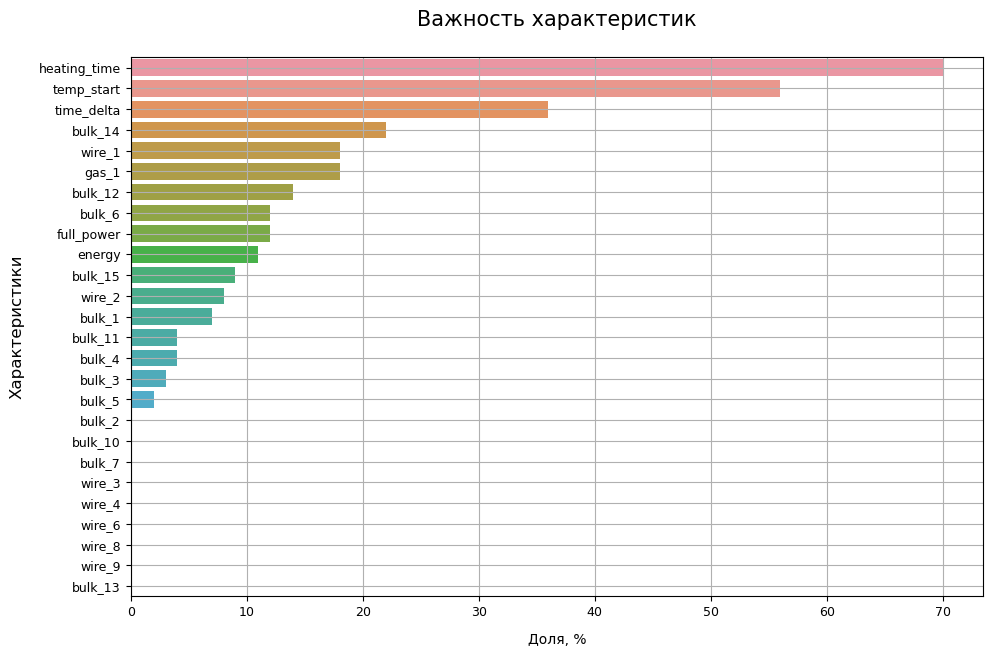

In [73]:
feature_importances = pd.Series(model_lgbm.feature_importances_, x_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)

plt.figure(figsize=(11, 7))
sns.barplot(x=feature_importances.values,
            y=feature_importances.index,            
            orient='h');
plt.title('Важность характеристик\n', fontsize=15)
plt.xlabel('Доля, %', fontsize=10, labelpad=10)
plt.ylabel('Характеристики', fontsize=12, labelpad=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid('on')
plt.show()

# 5 Тестирование  
    

## 5.1 Тестирование лучшей модели

### 5.1.1 Линейная регрессия

In [74]:
predictions_lr = model_lr.predict(x_test_sc)
lr_mae_test = mean_absolute_error(predictions_lr, y_test).round(3)
print('\nMAE модели линейной регрессии на тестовой выборке =', lr_mae_test)     


MAE модели линейной регрессии на тестовой выборке = 6.411


### 5.1.2 LightGBM

In [75]:
predictions_lgbm = model_lgbm.predict(x_test)
lgbm_mae_test = mean_absolute_error(predictions_lgbm, y_test).round(3)
print('\nMAE модели LGBM на тестовой выборке =', lgbm_mae_test)  


MAE модели LGBM на тестовой выборке = 6.041


**Вывод:**
Предположение подтвердилось. Лучшая метрика МАЕ на тесте оказалась у модели LGBM.

## 5.2 Сравнение с константной моделью

Посмотрим на метрику дамми модели по медиане:

In [76]:
dummy = DummyRegressor(strategy='median').fit(x_train, y_train)
dummy_predict = dummy.predict(x_test)
dummy_score = mean_absolute_error(y_test.values, dummy_predict).round(3)

print('\nMAE dummy-модели по медиане на тестовой выборке =', dummy_score) 


MAE dummy-модели по медиане на тестовой выборке = 8.207


**Вывод:**  Метрика нашей модели гораздо лучше, чем у константной. Модель адекватна.

<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">

<h1 align="center", style="margin-bottom: 15px">ВЫВОДЫ</h1>

## Итоги работы:
<p style="margin-bottom: 20px"></p> 
<div align="justify">$\;\;\;\;\;\;\;\;$В финальном проекте "Промышленность" на курсе "Специалист по DataScience" от Яндекс.Практикума была разработана модель машинного обучения на базе модели **LightGBM**, прогнозирующая температуру стали. Заказчиком проекта является Металлургический комбинат ООО «Так закаляем сталь». Модель разрабатывалась с целью снизить потребление электроэнергии на этапе обработки стали для оптимизации производственных расходов.</div>

Метрика **MAE** модели на тестовой выборке = **6.041.** При этом метрика константной модели по медиане = 8.7.

## Отчет о выполнении проекта:

<p style="margin-bottom: 20px"></p>
1. В ходе Исследовательского анализа и предобработки данных выполнено:

- датасеты загружены без ошибок;
- пропуски удалены или заменены на 0, т.к. замеры не производились;
- аномалии обработаны;
- объекты проверены на явные дубликаты;
- ключи по которым есть только 1 запись удалены;
- оставлены только уникальные значения ключей;
- ключи установлены в роли индексов;
- данные сагрегированы по ключам;
- имена столбцов приведены в соответствии со стандартом - английское название, snake_case, нижний регистр;
- выделен целевой признак - конечная температура `time_end`;
- выделены дополнительные признаки: 
    - начальная температура `temp_start`;
    - разница между первым и последним замерами температуры `time_delta`;
    - полная мощность `full_power`;
    - энергия `energy`.
    
<p style="margin-bottom: 40px"></p>
2. В ходе Подготовки к обучению моделей выполнена важная работа по подготовке тренировочных данных:

- все датасеты объеденены по пересечению ключей;
- выделены тестовая и тренировочная выборки в соотношении 25/75;
- итоговые объедененные данные предобработаны:
    - удалены столбцы с нулевыми значениями;
    - удалены коррелирующие (в том числе и нелинейно) признаки;
    - удалены аномалии по методу KNN.
<p style="margin-bottom: 5px"></p>    
- итоговый список используемых признаков:
'heating_time', 'full_power', 'energy', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_8', 'wire_9', 'temp_start', 'time_delta'.

<p style="margin-bottom: 40px"></p>
3. В ходе Обучения моделей были обучены 3 различных вида моделей:

- простая линейная регрессия LinearRegression;
- "деревянная" модель RandomForestRegressor;
- 2 модели градиентного бустинга - CatBoostRegressor и LGBMRegressor.

Перебор гиперпараметров осуществлялся автоматически с помощью GreadSearchCV на кросс-валидации.

<p style="margin-bottom: 40px"></p>
4. Выбор лучшей модели 

Метрики моделей на кросс-валидации представлены в таблице:

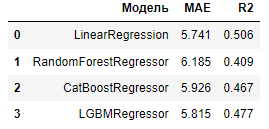

Лучшая модель по метрикам получаилась модель линейной регрессии. Но по опыту предыдущих работ, на тесте лучшей моделью может оказаться модель **LightGBM**. Поэтому в тестировании участвовали обе модели.  
 

<p style="margin-bottom: 30px"></p>
5. Тестирование лучшей модели

Метрика **MAE** модели **LinearRegression** на тесте = **6.411.**  
Метрика **MAE** модели **LightGBM** на тесте = **6.041.**   
Как и предполагалось модель LGBM показала лучшие результаты на тесте.
При этом метрика константной модели по медиане = 8.7. Найденная модель проходит проверку на адекватность.

Гиперпараметры итоговой модели **LightGBM**:

<table>
<tr>
  <th>Параметр</th>
  <th>Значение</th>
</tr>
<tr>
  <td>boosting_type</td>
  <td>gbdt</td>
</tr>    
<tr>
  <td>learning_rate</td>
  <td>0.26</td>
</tr>   
<tr>
  <td>max_depth</td>
  <td>2</td>
</tr> 
<tr>
  <td>n_estimators</td>
  <td>108</td>
</tr>
<tr>
  <td>random_state</td>
  <td>80523</td>
</tr>
</table>

<p style="margin-bottom: 30px"></p>
6. Визуализация важности характеристик 

Ниже представлены ТОП-10 важных характеристик и доля их важности в % для нашей модели, исходя из найденных весов.

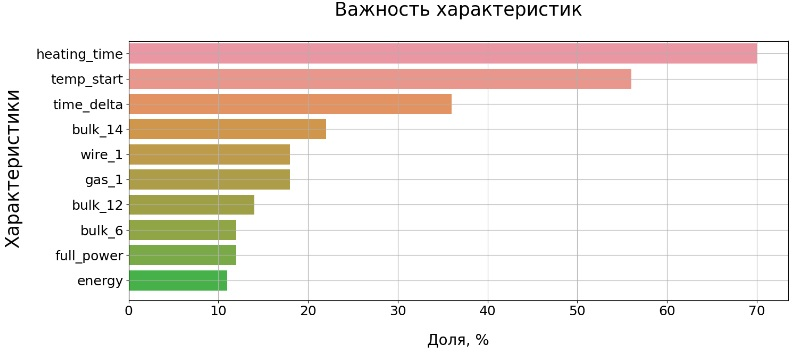

<p style="margin-bottom: 50px"></p> 
7. Рекомендации по улучшению проекта:

1) Увеличить кол-во данных.   
Для улучшения качества модели,  после объединения датасетов, необходимо больше данных.   
<p style="margin-bottom: -5px"></p>
2) Уточнить о заполнении пропусков.   
В датасетах по добавкам сыпучих материалов и проволоки имелось очень большое кол-во пропусков. Необходимо уточнить, действительно ли пропуск означает отсутствие добавок.  
<p style="margin-bottom: -5px"></p>
3) Провести более детальный анализ важности признаков.  
Получив в п.6 график важности характеристик, методом перебора были исключены все малозначимые хар-ки. Но метрика качества при этом не улучшалась. Т.к. найденная модель более чем удовлетворяла условиям задачи, то дальнейший анализ не проводился. Необходимо провести аналзи важности признаков и по другим моделям. На основании результатов попробовать исключать малозначимые признаки.
<p style="margin-bottom: -5px"></p>
4) Попробовать другие модели. Например XGBoost.
